<a href="https://colab.research.google.com/github/ingcarlosefren/DataScientist/blob/master/Instalacion_Pyspark_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Instalacion de Pyspark

In [1]:
#Realizamos la instalacion de spark
#Siempre que la sesin se cierre debemos realizar la instalacion ya que los recursos que se asignan no son los mismos
#este archivo colab.sh es un scrip que realiza la instalacion de manera automatizada.
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-09-16 08:15:43--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-09-16 08:15:44--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                     0%[                    ]       0  --.-KB/s               setup Colab for PySpark 3.0.3 and Spark NLP 3.2.3
-                   100%[==

In [2]:
# Cargar Pyspark Context
from pyspark import SparkConf, SparkContext
sc = SparkContext( conf = (SparkConf().setMaster("local").setAppName("My_app")))


In [3]:
# SparkContext version
sc

<SparkContext master=local appName=My_app>

In [4]:
# Python version
sc.pythonVer

'3.7'

#2. Configuracion de Google Drive para poder leer y guardar archivos 

In [6]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz

#ID_IBEX: 13mq7MdXncQMuObZH1Oet4hUxGoONTUzo
#ID_MNIST_TEST: 1AFA7I2RHc8dfSjMYhfuM5lB3HFQeS7VY
#ID_MNIST_TRAIN: 1bDL2oitGrqhDhCoKZ2IEdC8XrIdTJvOI
#ID:FOOD_INS: 1ZITkm3vlk3mglWU5LUwbFC0w46eRyr3Z

file_id = '1ZITkm3vlk3mglWU5LUwbFC0w46eRyr3Z'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

#3. Primer Ejemplo Practicas CSDM "IBEX.csv"

In [7]:
!ls -l drive/MyDrive/DatosPyspark/

total 309899
-rw------- 1 root root 189370978 Apr  9 15:22 Food_Inspections.csv
-rw------- 1 root root     20814 Apr  9 19:10 IBEX.csv
drwx------ 2 root root      4096 Apr  9 22:43 img
-rw------- 1 root root  18299443 Apr  9 21:56 mnist_test.csv
-rw------- 1 root root 109635994 Apr  9 21:28 mnist_train.csv
drwx------ 2 root root      4096 Apr 30 11:03 Output_Pyspark


In [8]:
#importamps 
raw_data = sc.textFile("drive/MyDrive/DatosPyspark/IBEX.csv")

In [9]:
raw_data.take(1)

['2020-03-23,6223.700195,6472.000000,6148.000000,6230.200195,6230.200195,282033200']

In [12]:
from pyspark import SparkConf, SparkContext
from collections import namedtuple
from datetime import datetime, timedelta

# definimos la cabecera de los datos
Record = namedtuple("Record", ["date", "open", "high", "low", "close", "adj_close", "volume"])

#creamos la funcion que importa los datos y convierte las columnas a tipos numericos flotantes
def parse_record(s):
    fields = s.split(",")
    return Record(fields[0], *map(float, fields[1:6]), int(fields[6]))

#incrementar 1 dia a la fecha introducida con el fin de hallar el valor del siguiente dia
def get_next_date(s):
    fmt="%Y-%m-%d"
    return(datetime.strptime(s,fmt) + timedelta(days=1)).strftime(fmt)

#Ejecutamos y Almacenamos en cache para facilitar el calculo
parsed_data = sc.textFile("drive/MyDrive/DatosPyspark/IBEX.csv").map(parse_record).cache()

#creamos un nuevo rdd con la fecha y el valor de cierre de la accion
date_and_close_price = parsed_data.map(lambda r: (r.date, r.close))

#creamos un nuevo rdd que contenga el valor al cierre de la accion del dia anterior y el dia actual para poder hallar el rendimiento
date_and_prev_close_price = parsed_data.map(lambda r: (get_next_date(r.date), r.close))

#une los dataset
joined = date_and_close_price.join(date_and_prev_close_price)

#calcular el rendimiento
returns=joined.mapValues(lambda p: (p[0]/p[1]-1.0)*100.0)

#imprime el resultado
print(returns.collect())

#guarda los datos en un solo archivo 
returns.repartition(1).saveAsTextFile("drive/MyDrive/DatosPyspark/Output_Pyspark")

[('2020-03-24', 7.818362087159203), ('2020-03-25', 3.351050325793814), ('2020-03-26', 1.3079092861510544), ('2020-03-27', -3.629930698993844), ('2020-03-31', 1.884412706598071), ('2020-04-03', 0.11408405543265054), ('2020-04-07', 2.304109981926783), ('2020-04-08', -0.7169408026278301), ('2020-04-09', 1.708914185281274), ('2020-04-15', -3.785556850718208), ('2020-04-22', 1.2795958379780092), ('2020-04-24', -1.9654650263099316), ('2020-04-28', 1.5538206724791337), ('2020-05-05', 1.1148965605330075), ('2020-05-07', 0.8873256481813474), ('2020-05-08', 0.7755307129807321), ('2020-05-15', -1.0801178645423515), ('2020-05-19', -2.510579438815652), ('2020-05-20', 1.1272336459625443), ('2020-05-21', 0.03740499077358184), ('2020-05-22', 0.17050151557571613), ('2020-05-27', 2.4357872097984234), ('2020-06-03', 2.9467717918516767), ('2020-06-05', 4.041342454942876), ('2020-06-09', -1.8211559024742252), ('2020-06-12', 0.20198124484749336), ('2020-06-16', 3.2510022500716884), ('2020-06-17', -0.2214669

#4. Segundo Ejemplo Machine Learning "Food_Inspections.csv"

### 4.0. Carga de lo Datos

In [ ]:
#1. importamos los datos 
raw_data = sc.textFile("drive/MyDrive/DatosPyspark/Food_Inspections.csv")

raw_data.take(1)

['Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location']

In [ ]:
#creamos un vector para las cabeceras
from collections import namedtuple
Record = namedtuple("Record", ["InspectionID", "DBAName", "AKAName", "LicenseN", "FacilityType",
"Risk", "Address", "City", "State", "Zip", "InspectionDate", "InspectionType", "Results",
"Violations", "Latitude", "Longitude", "Location"])


In [ ]:
#creamos la funcion que dividira el archivo
def parse_record(s):
  fields = s.split(",")
  return Record(*fields[0:17])

In [ ]:
#ejecutamos la funcion parse_record
parsed_data = raw_data.map(parse_record)

In [ ]:
parsed_data.take(1)

[Record(InspectionID='Inspection ID', DBAName='DBA Name', AKAName='AKA Name', LicenseN='License #', FacilityType='Facility Type', Risk='Risk', Address='Address', City='City', State='State', Zip='Zip', InspectionDate='Inspection Date', InspectionType='Inspection Type', Results='Results', Violations='Violations', Latitude='Latitude', Longitude='Longitude', Location='Location')]

In [ ]:
parsed_data.take(2)[1]

Record(InspectionID='70269', DBAName="mr.daniel's", AKAName="mr.daniel's", LicenseN='1899292', FacilityType='Restaurant', Risk='Risk 1 (High)', Address='5645 W BELMONT AVE ', City='CHICAGO', State='IL', Zip='60634', InspectionDate='01/04/2010', InspectionType='License Re-Inspection', Results='Pass', Violations='', Latitude='41.93844282365204', Longitude='-87.76831838068422', Location='"(-87.76831838068422')

In [ ]:
#para trabajar con dataframes se debe cargar previamente la libreria sql y crear la session en la variable spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Test_spark").master("local[*]").getOrCreate()

In [ ]:
#realizamos la carga ahora en un dataframe
fi=spark.read.options(header='true', delimiter=',').csv("drive/MyDrive/DatosPyspark/Food_Inspections.csv")
#revisemos el schema
fi.schema
#seleccionemos un registro del dataframe
fi.take(1)

[Row(Inspection ID='70269', DBA Name="mr.daniel's", AKA Name="mr.daniel's", License #='1899292', Facility Type='Restaurant', Risk='Risk 1 (High)', Address='5645 W BELMONT AVE ', City='CHICAGO', State='IL', Zip='60634', Inspection Date='01/04/2010', Inspection Type='License Re-Inspection', Results='Pass', Violations=None, Latitude='41.93844282365204', Longitude='-87.76831838068422', Location='(-87.76831838068422, 41.93844282365204)')]

In [ ]:
#mostremos los primeros 5 registros del dataframe
fi.show(5)

+-------------+--------------------+--------------------+---------+-------------+---------------+--------------------+-------+-----+-----+---------------+--------------------+-------+--------------------+------------------+------------------+--------------------+
|Inspection ID|            DBA Name|            AKA Name|License #|Facility Type|           Risk|             Address|   City|State|  Zip|Inspection Date|     Inspection Type|Results|          Violations|          Latitude|         Longitude|            Location|
+-------------+--------------------+--------------------+---------+-------------+---------------+--------------------+-------+-----+-----+---------------+--------------------+-------+--------------------+------------------+------------------+--------------------+
|        70269|         mr.daniel's|         mr.daniel's|  1899292|   Restaurant|  Risk 1 (High)| 5645 W BELMONT AVE |CHICAGO|   IL|60634|     01/04/2010|License Re-Inspec...|   Pass|                null| 41.

In [ ]:
#creamos el schema con el fin de asignar tipos de datos a nuestro gusto
from pyspark.sql.types import *
schema = StructType([
    StructField("Inspection ID",IntegerType()),
    StructField("DBA Name",StringType()),
    StructField("AKA Name",StringType()),
    StructField("License #",StringType()),
    StructField("Facility Type",StringType()),
    StructField("Risk",StringType()),
    StructField("Address",StringType()),
    StructField("City",StringType()),
    StructField("State",StringType()),
    StructField("Zip",StringType()),
    StructField("Inspection Date",StringType()),
    StructField("Inspection Type",StringType()),
    StructField("Results",StringType()),
    StructField("Violations",StringType()),
    StructField("Latitude",StringType()),
    StructField("Longitude",StringType()),
    StructField("Location",StringType())
])

In [ ]:
# Nuevamente importamos los datos y le asignamos el schema con el tipo de datos asignado
fi=spark.read.options(header='true',delimiter=',').schema(schema).csv ("drive/MyDrive/DatosPyspark/Food_Inspections.csv")
fi.schema

StructType(List(StructField(Inspection ID,IntegerType,true),StructField(DBA Name,StringType,true),StructField(AKA Name,StringType,true),StructField(License #,StringType,true),StructField(Facility Type,StringType,true),StructField(Risk,StringType,true),StructField(Address,StringType,true),StructField(City,StringType,true),StructField(State,StringType,true),StructField(Zip,StringType,true),StructField(Inspection Date,StringType,true),StructField(Inspection Type,StringType,true),StructField(Results,StringType,true),StructField(Violations,StringType,true),StructField(Latitude,StringType,true),StructField(Longitude,StringType,true),StructField(Location,StringType,true)))

### 4.1. En necesario dividir el dataframe en datos de entrenamiento y datos de prueba, por lo que el 80% de los datos aleatorios se utilizaran para el entrenamiento y el 20% restante se utilizará para pruebas. 

In [ ]:
#importamos la libreria para trabajar con dataframes
from pyspark.sql.dataframe import *


In [ ]:
#El daataframe original tiene 172.882 registros, entonces se dividira de forma aleatoria 80% y 20%
fi.count()

172882

In [ ]:
#el dataframe fi 
type(fi)

pyspark.sql.dataframe.DataFrame

In [ ]:
#se utiliza la funcion randomSplit para dividir el dataframe el 0 al final es el parametro seed() = o semilla para que sea aleatorio
# los 2 dataframes se guardan ahora en una colleccion de dataframes
df_list = fi.randomSplit([8.0, 2.0], 0)

In [ ]:
#Accedemos al primer registro de la coleccion y contamos cuantas filas tiene
df_list[0].count()


137993

In [ ]:
#Accedemos al segundo registro de la coleccion y contamos cuantas filas tiene
df_list[1].count()

34889

In [ ]:
#asignamos cada elemento de la colleccion a un nuevo data frame
fi1 = df_list[0]
fi2 = df_list[1]


In [ ]:
fi1.show(5)

+-------------+--------------------+--------------------+---------+-------------+-------------+--------------------+-------+-----+-----+---------------+--------------------+-------+--------------------+-----------------+------------------+--------------------+
|Inspection ID|            DBA Name|            AKA Name|License #|Facility Type|         Risk|             Address|   City|State|  Zip|Inspection Date|     Inspection Type|Results|          Violations|         Latitude|         Longitude|            Location|
+-------------+--------------------+--------------------+---------+-------------+-------------+--------------------+-------+-----+-----+---------------+--------------------+-------+--------------------+-----------------+------------------+--------------------+
|        44247|          EAT A PITA|          EAT A PITA|  1222441|   Restaurant|Risk 1 (High)|  3155 N HALSTED ST |CHICAGO|   IL|60657|     01/05/2010|           Complaint|   Pass|30. FOOD IN ORIGI...|41.939441157014

In [ ]:
fi2.show(5)

+-------------+--------------------+--------------------+---------+-------------+-------------+--------------------+-------+-----+-----+---------------+---------------+-------+--------------------+------------------+------------------+--------------------+
|Inspection ID|            DBA Name|            AKA Name|License #|Facility Type|         Risk|             Address|   City|State|  Zip|Inspection Date|Inspection Type|Results|          Violations|          Latitude|         Longitude|            Location|
+-------------+--------------------+--------------------+---------+-------------+-------------+--------------------+-------+-----+-----+---------------+---------------+-------+--------------------+------------------+------------------+--------------------+
|        48216|         Hanson Park|         Hanson Park|    24461|       School|Risk 1 (High)|5411 W Fullerton ...|CHICAGO|   IL|60639|     01/13/2010|        Canvass|   Pass|33. FOOD AND NON-...| 41.92392770522664|-87.761520944

In [ ]:
#seleccionamos fi1 como dataframe de entrenamiento y miramos el contenido de las variables de interes
fi1.select('Inspection ID', 'DBA Name', 'Results', 'Violations' ).show()

+-------------+--------------------+------------------+--------------------+
|Inspection ID|            DBA Name|           Results|          Violations|
+-------------+--------------------+------------------+--------------------+
|        44247|          EAT A PITA|              Pass|30. FOOD IN ORIGI...|
|        44248|          LA GONDOLA|              Pass|32. FOOD AND NON-...|
|        44249|Azha Restaurant Inc.|              Pass|35. WALLS, CEILIN...|
|        44250|SAINT JOSEPH HOSP...|              Pass|33. FOOD AND NON-...|
|        44251|SAINT JOSEPH HOSP...|              Pass|33. FOOD AND NON-...|
|        44252|  CHARTWELL'S DINING|              Pass|32. FOOD AND NON-...|
|        44253|      ROCKS LAKEVIEW|Pass w/ Conditions|10. SEWAGE AND WA...|
|        44254|              SUBWAY|              Pass|                null|
|        44255|TONY'S BURRITO ME...|              Fail|18. NO EVIDENCE O...|
|        44256|          EAT A PITA|Pass w/ Conditions|3. POTENTIALLY HA...|

In [ ]:
#creamos un nuevo dataframe con estas variables
fic = fi1.select('Inspection ID', 'DBA Name', 'Results', 'Violations' )
fic.show(5)

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|        44247|          EAT A PITA|   Pass|30. FOOD IN ORIGI...|
|        44248|          LA GONDOLA|   Pass|32. FOOD AND NON-...|
|        44249|Azha Restaurant Inc.|   Pass|35. WALLS, CEILIN...|
|        44250|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
|        44251|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
+-------------+--------------------+-------+--------------------+
only showing top 5 rows



In [ ]:
# ahora eliminamos los registros que no tenga algun campo no disponible, y muestre los primeros 5 
fic.dropna('any').show(5)

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|        44247|          EAT A PITA|   Pass|30. FOOD IN ORIGI...|
|        44248|          LA GONDOLA|   Pass|32. FOOD AND NON-...|
|        44249|Azha Restaurant Inc.|   Pass|35. WALLS, CEILIN...|
|        44250|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
|        44251|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
+-------------+--------------------+-------+--------------------+
only showing top 5 rows



In [ ]:
# ahora eliminamos siempre y cuando todo la fila sera nula  y muestreme los primero 5 
fic.dropna('all').show(5)

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|        44247|          EAT A PITA|   Pass|30. FOOD IN ORIGI...|
|        44248|          LA GONDOLA|   Pass|32. FOOD AND NON-...|
|        44249|Azha Restaurant Inc.|   Pass|35. WALLS, CEILIN...|
|        44250|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
|        44251|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
+-------------+--------------------+-------+--------------------+
only showing top 5 rows



In [ ]:
#ahora creamos un nuevo dataframe y le decimos que nos elimine los nulos que esten es las 2 columnas inspection y DBA name
ficne1=fic.dropna(subset=['Inspection ID','DBA Name'])

ficne1.show(5)

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|        44247|          EAT A PITA|   Pass|30. FOOD IN ORIGI...|
|        44248|          LA GONDOLA|   Pass|32. FOOD AND NON-...|
|        44249|Azha Restaurant Inc.|   Pass|35. WALLS, CEILIN...|
|        44250|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
|        44251|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
+-------------+--------------------+-------+--------------------+
only showing top 5 rows



In [ ]:
#creamos un nuevo datafrme que contiene valores nulos en las columnas results y violations y que me los llene con cadenas vacias
ficne=ficne1.na.fill({'Results':'', 'Violations':''})
ficne.show(5)

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|        44247|          EAT A PITA|   Pass|30. FOOD IN ORIGI...|
|        44248|          LA GONDOLA|   Pass|32. FOOD AND NON-...|
|        44249|Azha Restaurant Inc.|   Pass|35. WALLS, CEILIN...|
|        44250|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
|        44251|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
+-------------+--------------------+-------+--------------------+
only showing top 5 rows



In [ ]:
#Ahora hagamos un filtrado de la columna result para que nos muestre cuales con las categorias que tiene esa columna
ficne.select("Results").distinct().show()

+--------------------+
|             Results|
+--------------------+
|           Not Ready|
|                Fail|
|            No Entry|
|Business Not Located|
|  Pass w/ Conditions|
|     Out of Business|
|                Pass|
+--------------------+



In [ ]:
#crea una tabla temporal para poder realizar consultas SQL puras, la nueva tabla llamada CountResults
ficne.registerTempTable('CountResults')

In [ ]:
type('CountResults')

str

In [ ]:
#Creamos un dataframe nuevo que almacena la consulta realizada en SQL sobre la tabla anterior
#la siguiente consulta cuenta cuentos hay de cada categoria resultado
cr1 = spark.sql("SELECT COUNT(Results) AS Cnt, Results FROM CountResults GROUP BY Results")
cr1.show()

+-----+--------------------+
|  Cnt|             Results|
+-----+--------------------+
|  980|           Not Ready|
|26717|                Fail|
| 4084|            No Entry|
|   47|Business Not Located|
|13268|  Pass w/ Conditions|
|12196|     Out of Business|
|80701|                Pass|
+-----+--------------------+



In [ ]:
#cracion de listas a partir de un dataframe
type(cr1)

pyspark.sql.dataframe.DataFrame

In [ ]:
#cuando utilizamos collect() sobre dataframe nos devuelve una lista de filas
type(cr1.collect())

list

In [ ]:
#seleccionamos el primer elemento de la lista
cr1.collect()[0]

Row(Cnt=980, Results='Not Ready')

In [ ]:
#creamos 2 listas una para la columna contar y otra para los resultados
crl=cr1.collect()
cnt=list(map(lambda x: x.Cnt, crl))
results=list(map(lambda x: x.Results, crl))

In [ ]:
cnt

[980, 26717, 4084, 47, 13268, 12196, 80701]

In [ ]:
results


['Not Ready',
 'Fail',
 'No Entry',
 'Business Not Located',
 'Pass w/ Conditions',
 'Out of Business',
 'Pass']

([<matplotlib.patches.Wedge at 0x7f711cda8910>,
 [Text(1.0997262321346997, 0.02454005612904309, 'Not Ready'),
  Text(0.8737781940833201, 0.6682152853268861, 'Fail'),
  Text(0.2365101109169892, 1.0742732275515543, 'No Entry'),
  Text(0.1345809036140844, 1.09173622289563, 'Business Not Located'),
  Text(-0.19745192677668086, 1.0821334190441474, 'Pass w/ Conditions'),
  Text(-0.7579742353435359, 0.7971668950448094, 'Out of Business'),
  Text(-0.28965882961680317, -1.0611775357710056, 'Pass')],
 [Text(0.5998506720734725, 0.013385485161296229, '0.7%'),
  Text(0.4766062876818109, 0.364481064723756, '19.4%'),
  Text(0.12900551504563046, 0.5859672150281204, '3.0%'),
  Text(0.07340776560768239, 0.5954924852157981, '0.0%'),
  Text(-0.10770105096909864, 0.5902545922058985, '9.6%'),
  Text(-0.413440492005565, 0.43481830638807784, '8.8%'),
  Text(-0.157995725245529, -0.5788241104205485, '58.5%')])

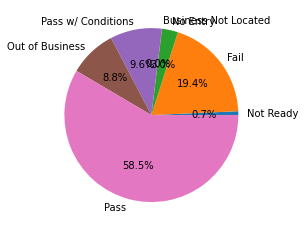

In [ ]:
#graficas
import matplotlib.pyplot as plt
plt.pie(cnt,labels=results,autopct='%1.1f%%')

In [ ]:
#seguimos trabajando con el dataframe ficne
ficne.show(5)

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|        44247|          EAT A PITA|   Pass|30. FOOD IN ORIGI...|
|        44248|          LA GONDOLA|   Pass|32. FOOD AND NON-...|
|        44249|Azha Restaurant Inc.|   Pass|35. WALLS, CEILIN...|
|        44250|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
|        44251|SAINT JOSEPH HOSP...|   Pass|33. FOOD AND NON-...|
+-------------+--------------------+-------+--------------------+
only showing top 5 rows



In [ ]:
#creamos una funcion para clasificar en valores categoricos(0,1) si un comercio paso o no la revision
def labelForResults(r):
  if r == 'Fail':
    return 0.0
  elif r == 'Pass w/ Conditions' or r == 'Pass':
    return 1.0
  else:
    return 1.0

In [ ]:
#invocamos la funcion
labelf=spark.udf.register('labelf', labelForResults, DoubleType())
type(labelf)

function

In [ ]:
#creamos una columna calculada de tipo dataframe utilizando la funcion 
labeledData=ficne.select(labelf(ficne.Results).alias('label'), ficne.Violations).where('label >= 0')
labeledData.show()


+-----+--------------------+
|label|          Violations|
+-----+--------------------+
|  1.0|30. FOOD IN ORIGI...|
|  1.0|32. FOOD AND NON-...|
|  1.0|35. WALLS, CEILIN...|
|  1.0|33. FOOD AND NON-...|
|  1.0|33. FOOD AND NON-...|
|  1.0|32. FOOD AND NON-...|
|  1.0|10. SEWAGE AND WA...|
|  1.0|                    |
|  0.0|18. NO EVIDENCE O...|
|  1.0|3. POTENTIALLY HA...|
|  1.0|2. FACILITIES TO ...|
|  1.0|40. REFRIGERATION...|
|  1.0|32. FOOD AND NON-...|
|  1.0|33. FOOD AND NON-...|
|  1.0|                    |
|  1.0|33. FOOD AND NON-...|
|  1.0|32. FOOD AND NON-...|
|  1.0|32. FOOD AND NON-...|
|  1.0|32. FOOD AND NON-...|
|  0.0|33. FOOD AND NON-...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
#seleccionamos 3 registros y mostramos el 2 registro
labeledData.take(3)[1]

Row(label=1.0, Violations='32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: All food and non-food contact equipment and utensils shall be smooth, easily cleanable, and durable, and shall be in good repair.  INTERIOR OF CHEST FREEZER DOOR HAS EXPOSED INSULATION AND CRACKED PLASTIC.  MUST REPAIR OR REPLACE. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: All food and non-food contact surfaces of equipment and all food storage utensils shall be thoroughly cleaned and sanitized daily.  DETAIL CLEAN THE INTERIOR OF THE MICROWAVE AND THE VENTILATION HOOD. | 38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: REPAIR THE DRAIN STOPPER FOR THE RIGHT COMPARTMENT OF THE 3 COMPARTMENT SINK SO THAT IT CAN BE USED TO HOLD WATER.')

###4.2. Spark ML
Se utiliza una libreria de sparl ML para tokenizar las palabras que contiene la columna Violations de tal manera que tengamos identificadas las palabras que se utilicen en cada categorioa (0) que no paso y que palabras se utilizaron y (1) cuando pasa la evaluacion que palabras se utilizaron.

In [ ]:
#importamos la libreria de machine learning
from pyspark.ml.feature import Tokenizer


In [ ]:
#para sacar las palabras claves e identificarlas utiliza tokenizer sobre cada una de las filas de la columna violations
tokenizer = Tokenizer(inputCol="Violations", outputCol="words")
type(tokenizer)
print(tokenizer)


Tokenizer_478a4e473cfc


In [ ]:
#invocamos la funcion tokenizer sobre el dataframe labeledData para que transforme las palabras en tokens
labeledDataTokens=tokenizer.transform(labeledData)
type(labeledDataTokens)
labeledDataTokens.show()

+-----+--------------------+--------------------+
|label|          Violations|               words|
+-----+--------------------+--------------------+
|  1.0|30. FOOD IN ORIGI...|[30., food, in, o...|
|  1.0|32. FOOD AND NON-...|[32., food, and, ...|
|  1.0|35. WALLS, CEILIN...|[35., walls,, cei...|
|  1.0|33. FOOD AND NON-...|[33., food, and, ...|
|  1.0|33. FOOD AND NON-...|[33., food, and, ...|
|  1.0|32. FOOD AND NON-...|[32., food, and, ...|
|  1.0|10. SEWAGE AND WA...|[10., sewage, and...|
|  1.0|                    |                  []|
|  0.0|18. NO EVIDENCE O...|[18., no, evidenc...|
|  1.0|3. POTENTIALLY HA...|[3., potentially,...|
|  1.0|2. FACILITIES TO ...|[2., facilities, ...|
|  1.0|40. REFRIGERATION...|[40., refrigerati...|
|  1.0|32. FOOD AND NON-...|[32., food, and, ...|
|  1.0|33. FOOD AND NON-...|[33., food, and, ...|
|  1.0|                    |                  []|
|  1.0|33. FOOD AND NON-...|[33., food, and, ...|
|  1.0|32. FOOD AND NON-...|[32., food, and, ...|


In [ ]:
labeledDataTokens.take(1)


[Row(label=1.0, Violations="30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: CUSTOMER ADVISORY POSTED AS NEEDED - Comments: All food not stored in the original container shall be stored in properly labeled containers.  OBSERVED SEVERAL FOODS IN COOLERS WITHOUT A LABEL AND DATE.  MUST LABEL AND DATE ALL PREPARED FOODS. | 32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: OBSERVED TORN DOOR GASKET ON DOOR OF 'CHILL ISLE' REACH-IN COOLER.  MUST REPLACE.  OBSERVED EXPOSED INSULATION INSIDE OF THE 2 DOOR PREP COOLER.  MUST REPAIR.  REPLACE THE CRACKED LIGHT SHIELD IN THE REAR AREA OVER THE PREP TABLE.  OBSERVED CARDBOARD STORED INSIDE OF THE DRESSING COOLER AND ON WIRE RACKS IN THE BASEMENT WALK-IN COOLER.  MUST REMOVE CARDBOARD. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: All food and non-food contact surfaces of equipment and all food storage utensils shall be thoroughly cleaned and saniti

In [ ]:
labeledDataTokens.take(3)[1]

Row(label=1.0, Violations='32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: All food and non-food contact equipment and utensils shall be smooth, easily cleanable, and durable, and shall be in good repair.  INTERIOR OF CHEST FREEZER DOOR HAS EXPOSED INSULATION AND CRACKED PLASTIC.  MUST REPAIR OR REPLACE. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: All food and non-food contact surfaces of equipment and all food storage utensils shall be thoroughly cleaned and sanitized daily.  DETAIL CLEAN THE INTERIOR OF THE MICROWAVE AND THE VENTILATION HOOD. | 38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: REPAIR THE DRAIN STOPPER FOR THE RIGHT COMPARTMENT OF THE 3 COMPARTMENT SINK SO THAT IT CAN BE USED TO HOLD WATER.', words=['32.', 'food', 'and', 'non-food', 'contact', 'surfaces', 'properly', 'designed,', 'constructed', 'and', 'maintained'

### 4.3. Modelo: cómputo de la frecuencia acumulada de los tokens

In [ ]:
#importamos la libreria de ML HashingTF para asignar un id a cada palabra
from pyspark.ml.feature import HashingTF


In [ ]:
# Configuramos la funcion hash los parametros  "inputColque" y "outputCol" 
#reciba como entrada la funcion tokenizer y como salida la columna calculada features
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")


In [ ]:
#invocamos la funcion hash y recibe como entrada el dataframe labeledDataTokens
labeledDataTokensTF=hashingTF.transform(labeledDataTokens)

labeledDataTokensTF.show()

+-----+--------------------+--------------------+--------------------+
|label|          Violations|               words|            features|
+-----+--------------------+--------------------+--------------------+
|  1.0|30. FOOD IN ORIGI...|[30., food, in, o...|(262144,[6106,649...|
|  1.0|32. FOOD AND NON-...|[32., food, and, ...|(262144,[5765,610...|
|  1.0|35. WALLS, CEILIN...|[35., walls,, cei...|(262144,[12650,27...|
|  1.0|33. FOOD AND NON-...|[33., food, and, ...|(262144,[1508,542...|
|  1.0|33. FOOD AND NON-...|[33., food, and, ...|(262144,[1508,542...|
|  1.0|32. FOOD AND NON-...|[32., food, and, ...|(262144,[1508,610...|
|  1.0|10. SEWAGE AND WA...|[10., sewage, and...|(262144,[6106,914...|
|  1.0|                    |                  []|(262144,[249180],...|
|  0.0|18. NO EVIDENCE O...|[18., no, evidenc...|(262144,[161,2786...|
|  1.0|3. POTENTIALLY HA...|[3., potentially,...|(262144,[1689,610...|
|  1.0|2. FACILITIES TO ...|[2., facilities, ...|(262144,[1415,168...|
|  1.0

### 4.4. Modelo: entrenamiento del regresor

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
lr = LogisticRegression(maxIter=10, regParam=0.01)

In [ ]:
model = lr.fit(labeledDataTokensTF)

In [ ]:
print("Multinomial coefficients: " + str(model.coefficientMatrix))

Multinomial coefficients: 1 X 262144 CSRMatrix
(0,2) 1.1251
(0,4) 0.9196
(0,6) 0.7991
(0,7) 0.3432
(0,8) 0.4757
(0,10) -0.3173
(0,11) 0.9977
(0,13) -0.063
(0,15) 0.4569
(0,16) 2.9566
(0,20) 0.5423
(0,21) -0.1699
(0,22) 0.4648
(0,23) -0.3612
(0,24) -0.5218
(0,25) -0.2157
..
..


### 4.5. Predicción: preparación de los datos

Preparamos el dataframe de pruebas fi2

In [ ]:
fi2.show(5)

+-------------+--------------------+--------------------+---------+-------------+-------------+--------------------+-------+-----+-----+---------------+---------------+-------+--------------------+------------------+------------------+--------------------+
|Inspection ID|            DBA Name|            AKA Name|License #|Facility Type|         Risk|             Address|   City|State|  Zip|Inspection Date|Inspection Type|Results|          Violations|          Latitude|         Longitude|            Location|
+-------------+--------------------+--------------------+---------+-------------+-------------+--------------------+-------+-----+-----+---------------+---------------+-------+--------------------+------------------+------------------+--------------------+
|        48216|         Hanson Park|         Hanson Park|    24461|       School|Risk 1 (High)|5411 W Fullerton ...|CHICAGO|   IL|60639|     01/13/2010|        Canvass|   Pass|33. FOOD AND NON-...| 41.92392770522664|-87.761520944

In [ ]:
#creamos un nuevo dataframe con estas variables
fic2 = fi2.select('Inspection ID', 'DBA Name', 'Results', 'Violations' )
fic2.show(5)

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|        48216|         Hanson Park|   Pass|33. FOOD AND NON-...|
|        48217|  Hanson Park Branch|   Pass|34. FLOORS: CONST...|
|        48224|JOE'S BARBECUE & ...|   Fail|34. FLOORS: CONST...|
|        48225|SHRINERS HOSPITAL...|   Pass|32. FOOD AND NON-...|
|        48226|SHRINERS HOSPITAL...|   Pass|32. FOOD AND NON-...|
+-------------+--------------------+-------+--------------------+
only showing top 5 rows



In [ ]:
#ahora creamos un nuevo dataframe y le decimos que nos elimine los nulos que esten es las 2 columnas inspection y DBA name
ficne2=fic2.dropna(subset=['Inspection ID','DBA Name'])

ficne2.show(5)

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|        48216|         Hanson Park|   Pass|33. FOOD AND NON-...|
|        48217|  Hanson Park Branch|   Pass|34. FLOORS: CONST...|
|        48224|JOE'S BARBECUE & ...|   Fail|34. FLOORS: CONST...|
|        48225|SHRINERS HOSPITAL...|   Pass|32. FOOD AND NON-...|
|        48226|SHRINERS HOSPITAL...|   Pass|32. FOOD AND NON-...|
+-------------+--------------------+-------+--------------------+
only showing top 5 rows



In [ ]:
#creamos un nuevo datafrme que contiene valores nulos en las columnas results y violations y que me los llene con cadenas vacias
ficneTest=ficne2.na.fill({'Results':'', 'Violations':''})
ficneTest.show(5)

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|        48216|         Hanson Park|   Pass|33. FOOD AND NON-...|
|        48217|  Hanson Park Branch|   Pass|34. FLOORS: CONST...|
|        48224|JOE'S BARBECUE & ...|   Fail|34. FLOORS: CONST...|
|        48225|SHRINERS HOSPITAL...|   Pass|32. FOOD AND NON-...|
|        48226|SHRINERS HOSPITAL...|   Pass|32. FOOD AND NON-...|
+-------------+--------------------+-------+--------------------+
only showing top 5 rows



In [ ]:
# Calculo la columna de palabras 
testDfTokens=tokenizer.transform(ficneTest)

testDfTokens.show(5)

+-------------+--------------------+-------+--------------------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|               words|
+-------------+--------------------+-------+--------------------+--------------------+
|        48216|         Hanson Park|   Pass|33. FOOD AND NON-...|[33., food, and, ...|
|        48217|  Hanson Park Branch|   Pass|34. FLOORS: CONST...|[34., floors:, co...|
|        48224|JOE'S BARBECUE & ...|   Fail|34. FLOORS: CONST...|[34., floors:, co...|
|        48225|SHRINERS HOSPITAL...|   Pass|32. FOOD AND NON-...|[32., food, and, ...|
|        48226|SHRINERS HOSPITAL...|   Pass|32. FOOD AND NON-...|[32., food, and, ...|
+-------------+--------------------+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#calculo la columna de hash para cada palabra
testDfTokensTF=hashingTF.transform(testDfTokens)
testDfTokensTF.show(5)

+-------------+--------------------+-------+--------------------+--------------------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|               words|            features|
+-------------+--------------------+-------+--------------------+--------------------+--------------------+
|        48216|         Hanson Park|   Pass|33. FOOD AND NON-...|[33., food, and, ...|(262144,[6106,802...|
|        48217|  Hanson Park Branch|   Pass|34. FLOORS: CONST...|[34., floors:, co...|(262144,[5429,685...|
|        48224|JOE'S BARBECUE & ...|   Fail|34. FLOORS: CONST...|[34., floors:, co...|(262144,[6787,802...|
|        48225|SHRINERS HOSPITAL...|   Pass|32. FOOD AND NON-...|[32., food, and, ...|(262144,[3618,610...|
|        48226|SHRINERS HOSPITAL...|   Pass|32. FOOD AND NON-...|[32., food, and, ...|(262144,[3618,610...|
+-------------+--------------------+-------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#aplico el modelo previamente entrenado 
predictionsDf = model.transform(testDfTokensTF)


In [ ]:
predictionsDf.select(['Inspection ID', 'DBA Name', 'Results', 'Violations','prediction']).show(10)


+-------------+--------------------+------------------+--------------------+----------+
|Inspection ID|            DBA Name|           Results|          Violations|prediction|
+-------------+--------------------+------------------+--------------------+----------+
|        48216|         Hanson Park|              Pass|33. FOOD AND NON-...|       1.0|
|        48217|  Hanson Park Branch|              Pass|34. FLOORS: CONST...|       1.0|
|        48224|JOE'S BARBECUE & ...|              Fail|34. FLOORS: CONST...|       1.0|
|        48225|SHRINERS HOSPITAL...|              Pass|32. FOOD AND NON-...|       1.0|
|        48226|SHRINERS HOSPITAL...|              Pass|32. FOOD AND NON-...|       1.0|
|        52235|     Lake View (H/S)|              Fail|6. HANDS WASHED A...|       0.0|
|        52236|     Lakeview Subway|Pass w/ Conditions|4. SOURCE OF CROS...|       1.0|
|        52238|       DISNEY MAGNET|              Fail|16. FOOD PROTECTE...|       0.0|
|        52248|APPLE TREE LEARNI

### 4.6. Predicción: calidad de los resultados

In [ ]:
#creamos una tabla temporal
predictionsDf.registerTempTable('Predictions')

In [ ]:
#Contamos cuantas predicciones acertamos de las  34.889 del dataframe de pruebas
numSuccesses=predictionsDf.where("(prediction = 0 AND results = 'Fail') OR ( prediction = 1 AND (results = 'Pass' OR results = 'Pass w/ Conditions'))").count()

print(numSuccesses)

28419


In [ ]:
numInspections = predictionsDf.count()
print(numInspections)

34889


In [ ]:
#calculamos el porcentaje de aciertos
print ("Este es un", str((float(numSuccesses) / float(numInspections)) * 100) + "%", "de aciertos")

Este es un 81.4554730717418% de aciertos


### 4.7. Predicción con un modelo entrenado en pipeline

Los pipeslines permiten ejecutar el mismo programa anterior pero almacenado en funciones que se ejcutan por fases.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF
from pyspark.ml.classification import LogisticRegression

tokenizer = Tokenizer(inputCol="Violations", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

model = pipeline.fit(labeledData)


In [ ]:
#cargamos los datos
testDfTmp1=spark.read.options(header='true',delimiter=',').schema(schema).csv("drive/MyDrive/DatosPyspark/Food_Inspections.csv").select('Inspection ID', 'DBA Name', 'Results', 'Violations').where("results ='Fail' OR results = 'Pass' OR results = 'Pass w/ Conditions'")

testDfTmp1.show(5)

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|        70269|         mr.daniel's|   Pass|                null|
|       104236|          TEMPO CAFE|   Fail|18. NO EVIDENCE O...|
|        67733|           WOLCOTT'S|   Pass|                null|
|        67757|DUNKIN DONUTS/BAS...|   Pass|                null|
|        67732|           WOLCOTT'S|   Pass|                null|
+-------------+--------------------+-------+--------------------+
only showing top 5 rows



In [ ]:
#sacamos el dataframe de entrenamiento esta vez veamos si tomando solo el 5% de los datos basta para adquirir un modelo bien entrenado
#se utiliza la funcion randomSplit para dividir el dataframe el 0 al final es el parametro seed() = o semilla para que sea aleatorio
# los 2 dataframes se guardan ahora en una colleccion de dataframes
df_list = fi.randomSplit([8.0, 2.0], 0)
fi1 = df_list[0]
fi2 = df_list[1]


In [ ]:
testDfTmp2=testDfTmp1.dropna(subset=['Inspection ID','DBA Name'])
testDf=testDfTmp2.na.fill({'Results':'', 'Violations':''})


In [ ]:
predictionsDf = model.transform(testDf)
predictionsDf.registerTempTable('Predictions')
predictionsDf.columns

['Inspection ID',
 'DBA Name',
 'Results',
 'Violations',
 'words',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [ ]:
numSuccesses = predictionsDf.where("(prediction = 0 AND results = 'Fail') OR (prediction = 1 AND (results = 'Pass' OR results = 'Pass w/ Conditions'))").count()
type(numSuccesses)

int

In [ ]:
numInspections = predictionsDf.count()

In [ ]:
print("There were", numInspections, "inspections and there were", numSuccesses, "successful predictions")


There were 151219 inspections and there were 145928 successful predictions


In [ ]:
print ("This is a", str((float(numSuccesses) / float(numInspections)) * 100) + "%", "success rate")


This is a 96.50110105211647% success rate


###4.8. Calidad de la predicción: positivos acertados

In [ ]:
true_negative = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND results = 'Fail'")
type(true_negative)

pyspark.sql.dataframe.DataFrame

In [ ]:
true_negative.show()

+-----+
|  cnt|
+-----+
|28946|
+-----+



In [ ]:
false_negative=spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND (results = 'Pass' OR results = 'Pass w/ Conditions')")

In [ ]:
true_positive=spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND (results = 'Pass' OR results = 'Pass w/ Conditions')") 

In [ ]:
false_positive=spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND results = 'Fail'")

###4.9. Grafico

In [ ]:
import matplotlib.pyplot as plt
labels = ['True positive', 'False positive', 'True negative', 'False negative']
sizes = [true_positive.collect()[0]['cnt'], false_positive.collect()[0]['cnt'], true_negative.collect()[0]['cnt'], false_negative.collect()[0]['cnt']]

([<matplotlib.patches.Wedge at 0x7f711a5d2710>,
 [Text(-0.8332811839386138, 0.7180824942120941, 'True positive'),
  Text(0.2652717688232973, -1.0675349589898024, 'False positive'),
  Text(0.8884629713839827, -0.6485626789135686, 'True negative'),
  Text(1.0998826828045265, -0.01606499507369095, 'False negative')],
 [Text(-0.45451700942106205, 0.391681360479324, '77.4%'),
  Text(0.14469369208543487, -0.5822917958126195, '3.0%'),
  Text(0.48461616620944503, -0.3537614612255828, '19.1%'),
  Text(0.5999360088024689, -0.00876272458564961, '0.5%')])

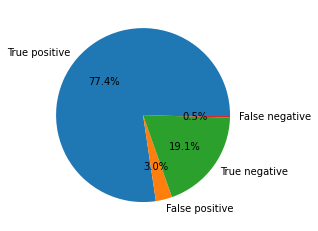

In [ ]:
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

Text(0.5, 1.0, 'Resuls stats')

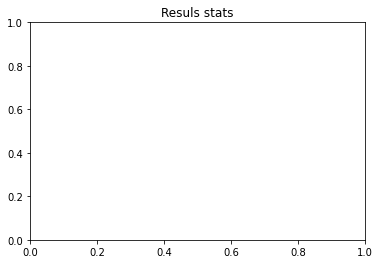

In [ ]:
plt.title('Resuls stats')

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

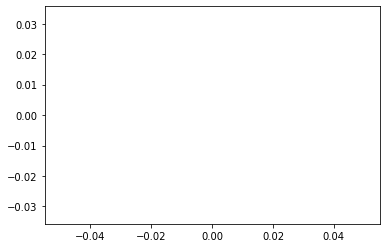

In [ ]:
plt.axis('equal')

In [ ]:
plt.show()

#5. Spark Streaming

In [ ]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext

In [ ]:
#Crea el SparkContext con n hilos de procesamiento
#sc = SparkContext ("local[*]", "ContadorDePalabrasRecibidas")
sc.setLogLevel("ERROR")
print("interfaz de usuario: "+ sc.uiWebUrl)

interfaz de usuario: http://e5e7d6e7e22f:4040


In [ ]:
# Crea un StreamingContext con intervalos de n segundos
ssc = StreamingContext (sc, 5)

In [ ]:
# Crea un DStream que conecta con un flujo de texto de internet (servidor)
lineas = ssc.socketTextStream("35.245.110.151",  9999)


In [ ]:
# Divide cada línea en palabras
palabras = lineas.flatMap(lambda line: line.split(" "))

In [ ]:
## Cuenta las ocurrencias de cada palabra en cada lote (RDD)
parejas = palabras.map(lambda word: (word, 1))

contadorPalabras = parejas.reduceByKey(lambda x, y: x + y)

In [ ]:
# Muestra los primeros 10 elementos de cada lote (RDD) del DStream
contadorPalabras.pprint()

#6. Proyecto Final

# COMPUTACIÓN SOBRE DATOS MASIVOS.

Proyecto Asignatura

* Docente: FRANCISCO DE ASÍS GUINDOS ROJAS
* Alumno: CARLOS EFRÉN FERNÁNDEZ ABAD

Implemente un modelo de clasificacion de imagenes

* Conjunto de datos:http://yann.lecun.com/exdb/mnist/
* Conversion de conjunto de datos: https://github.com/egcode/MNIST-to-CSV
* Modelo de regresion: https://cutt.ly/lc1ovtE
* Plataforma de implementacion: https://colab.research.google.com/ 
* Instalacion Pyspark:  http://setup.johnsnowlabs.com/colab.sh


<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png">

<img src="https://miro.medium.com/max/2400/0*nh3HnqO3diLen7iz.png">

El conjunto de datos MNIST es un conjunto de dígitos de caracteres escritos a
mano derivados de la base de datos especial NIST 19 y convertidos a un formato de imagen de 28x28 píxeles en escala de grises.

El conjunto de entrenamiento contiene 60.000 ejemplos (filas) y el conjunto de prueba 10.000 ejemplos (filas), no tiene cabeceras, cada fila del conjunto de datos contiene 785 columnas (28x28 píxeles aprox), con la primera columna como etiqueta para identificar a que numero pertenece y las otras 784 columnas corrresponden a los pixeles y cada valor de píxel tiene un rango de [0-255].

El siguiente algoritmo implementa un modelo de aprendizaje supervisado dentro del campo  de machine learning, el modelo de regresion logistica, este modelo permite clasificar las imagenes de numeros escritos a mano realizando predecciones a partir del entrenamiento previo del modelo.

### 6.1 Carga de los datos de entrenamiento

In [ ]:
# Cargamos una sesion spark, que es diferente de un sparkcontext, el spark context nos permite trabajar con rdd en versiones inferiores a spark 2.0
# pero si necesitamos trabajar  con dataframes adicionalmente se debe configurar el sparkconf(), el sparksession se incluyo desde la version 2.0 de spark 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Test_spark").master("local[*]").getOrCreate()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [ ]:
#creamos un dataframe llamado df_training que contendra el conjunto de datos de entrenamiento  "mnist_train.csv"
#
df_training = (spark
               .read
               .options(header = False, inferSchema = True)
               .csv("drive/MyDrive/DatosPyspark/mnist_train.csv"))

In [ ]:
#leemos el schema
df_training.schema


StructType(List(StructField(_c0,IntegerType,true),StructField(_c1,IntegerType,true),StructField(_c2,IntegerType,true),StructField(_c3,IntegerType,true),StructField(_c4,IntegerType,true),StructField(_c5,IntegerType,true),StructField(_c6,IntegerType,true),StructField(_c7,IntegerType,true),StructField(_c8,IntegerType,true),StructField(_c9,IntegerType,true),StructField(_c10,IntegerType,true),StructField(_c11,IntegerType,true),StructField(_c12,IntegerType,true),StructField(_c13,IntegerType,true),StructField(_c14,IntegerType,true),StructField(_c15,IntegerType,true),StructField(_c16,IntegerType,true),StructField(_c17,IntegerType,true),StructField(_c18,IntegerType,true),StructField(_c19,IntegerType,true),StructField(_c20,IntegerType,true),StructField(_c21,IntegerType,true),StructField(_c22,IntegerType,true),StructField(_c23,IntegerType,true),StructField(_c24,IntegerType,true),StructField(_c25,IntegerType,true),StructField(_c26,IntegerType,true),StructField(_c27,IntegerType,true),StructField(_c

In [ ]:
type(df_training)

pyspark.sql.dataframe.DataFrame

El eschema del dataframe es el siguiente:

* StructType(List(
    * StructField(_c0,IntegerType,true),
    * StructField(_c1,IntegerType,true),
    * StructField(_c2,IntegerType,true),
    * StructField(_c3,IntegerType,true),
    * StructField(_c4,IntegerType,true),
    * StructField(_c5,IntegerType,true),
    * ...
    * ...
    * ...
    * StructField(_c780,IntegerType,true),
    * StructField(_c781,IntegerType,true),
    * StructField(_c782,IntegerType,true),
    * StructField(_c783,IntegerType,true),
    * StructField(_c784,IntegerType,true)))

Se observa que tiene 785 columnas (0-784) 

In [ ]:
# miremos los primeros 10 registos
df_training.show(10)

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
#cuenta cuantas filas tiene el dataframe, no tiene cabeceras
df_training.count()

60000

### 5.2. Modificacion del dataframe

In [ ]:
#imprime el numero de columnas que tiene el dataframe y despues imprime su contenido
print("No of columns: ", len(df_training.columns), df_training.columns)

No of columns:  785 ['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13', '_c14', '_c15', '_c16', '_c17', '_c18', '_c19', '_c20', '_c21', '_c22', '_c23', '_c24', '_c25', '_c26', '_c27', '_c28', '_c29', '_c30', '_c31', '_c32', '_c33', '_c34', '_c35', '_c36', '_c37', '_c38', '_c39', '_c40', '_c41', '_c42', '_c43', '_c44', '_c45', '_c46', '_c47', '_c48', '_c49', '_c50', '_c51', '_c52', '_c53', '_c54', '_c55', '_c56', '_c57', '_c58', '_c59', '_c60', '_c61', '_c62', '_c63', '_c64', '_c65', '_c66', '_c67', '_c68', '_c69', '_c70', '_c71', '_c72', '_c73', '_c74', '_c75', '_c76', '_c77', '_c78', '_c79', '_c80', '_c81', '_c82', '_c83', '_c84', '_c85', '_c86', '_c87', '_c88', '_c89', '_c90', '_c91', '_c92', '_c93', '_c94', '_c95', '_c96', '_c97', '_c98', '_c99', '_c100', '_c101', '_c102', '_c103', '_c104', '_c105', '_c106', '_c107', '_c108', '_c109', '_c110', '_c111', '_c112', '_c113', '_c114', '_c115', '_c116', '_c117', '_c118', '_c119', '_c120', 

In [ ]:
#Se crea un vector que contiene las cabeceras del dataframe, que tiene 785 columnas, y luego imprime el contenido del vector
# str() convierte en cadena para que pueda ser concatenado con "_c", se observa que la primera posicion de la fila es _c1
# lo anterior porque _c0 es realmente label.
feature_culumns = ["_c" + str(i+1) for i in range(784)]
print(feature_culumns)

['_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13', '_c14', '_c15', '_c16', '_c17', '_c18', '_c19', '_c20', '_c21', '_c22', '_c23', '_c24', '_c25', '_c26', '_c27', '_c28', '_c29', '_c30', '_c31', '_c32', '_c33', '_c34', '_c35', '_c36', '_c37', '_c38', '_c39', '_c40', '_c41', '_c42', '_c43', '_c44', '_c45', '_c46', '_c47', '_c48', '_c49', '_c50', '_c51', '_c52', '_c53', '_c54', '_c55', '_c56', '_c57', '_c58', '_c59', '_c60', '_c61', '_c62', '_c63', '_c64', '_c65', '_c66', '_c67', '_c68', '_c69', '_c70', '_c71', '_c72', '_c73', '_c74', '_c75', '_c76', '_c77', '_c78', '_c79', '_c80', '_c81', '_c82', '_c83', '_c84', '_c85', '_c86', '_c87', '_c88', '_c89', '_c90', '_c91', '_c92', '_c93', '_c94', '_c95', '_c96', '_c97', '_c98', '_c99', '_c100', '_c101', '_c102', '_c103', '_c104', '_c105', '_c106', '_c107', '_c108', '_c109', '_c110', '_c111', '_c112', '_c113', '_c114', '_c115', '_c116', '_c117', '_c118', '_c119', '_c120', '_c121', '_c122', '_c123', 

In [ ]:
#Importamos la libreria ensamblador de vector para asignarle la cabecera al dataframe y la columna label
from pyspark.ml.feature import VectorAssembler

In [ ]:
#La regresión logística es un método popular para predecir una respuesta categórica a partir de un conjunto de caracteristicas 
#
#realizamos una transformacion del dataframe con 745 columnas a solo 2 columnas
# crea un nuevo vector llamado vectorizer y le asigna 784 columnas desde las _c1 hasta la _c784 y le asigna la etiqueta features
#la funcion VectorAssembler recibe 
vectorizer = VectorAssembler(inputCols=feature_culumns, outputCol="features")

training = (vectorizer
            .transform(df_training)
            .select("_c0", "features")
            .toDF("label", "features")
            .cache())
training.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    5|(784,[152,153,154...|
|    0|(784,[127,128,129...|
|    4|(784,[160,161,162...|
|    1|(784,[158,159,160...|
|    9|(784,[208,209,210...|
|    2|(784,[155,156,157...|
|    1|(784,[124,125,126...|
|    3|(784,[151,152,153...|
|    1|(784,[152,153,154...|
|    4|(784,[134,135,161...|
|    3|(784,[123,124,125...|
|    5|(784,[216,217,218...|
|    3|(784,[143,144,145...|
|    6|(784,[72,73,74,99...|
|    1|(784,[151,152,153...|
|    7|(784,[211,212,213...|
|    2|(784,[151,152,153...|
|    8|(784,[159,160,161...|
|    6|(784,[100,101,102...|
|    9|(784,[209,210,211...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
#training es un dataframe
type(training)

pyspark.sql.dataframe.DataFrame

### 5.3. Graficas
A continuacion se realizara una grafica de la primera linea del dataframe para comprender como se forma la imagen a partir del vector.

para realizar la grafica es sumamente importante comprender el concepto de array de pyhton, especificamente los array de tipo numpy.

<img src= "https://aprendeconalf.es/docencia/python/manual/img/arrays.png">

In [ ]:
#creamos un objeto de python tipo numpy array para poder graficar el primer registro del dataframe
# tome del dataframe training el primero de la columna features y conviertalo a un array de python
a = training.first().features.toArray()
type(a)

#en esta ocacion solo tenemos un vector de una dimension se observan solo 2 corchetes al inicio y al final 
print(a)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0. 

In [ ]:
#utilizandon la funcion reshape podemos crear con ese mismo vector la nueva dimension que querramos
#en este caso queremos recostruir la imagen cada vector tendra 28 posiciones x 28 vectores
print(a.reshape(28, 28))

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.  

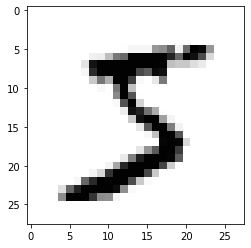

In [ ]:
#ahora con la funcion imshow de plot mostramos el vector de 2 dimensiones en escala de grises
plt.imshow(a.reshape(28, 28), cmap="Greys")

In [ ]:
df_training.show(1)

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

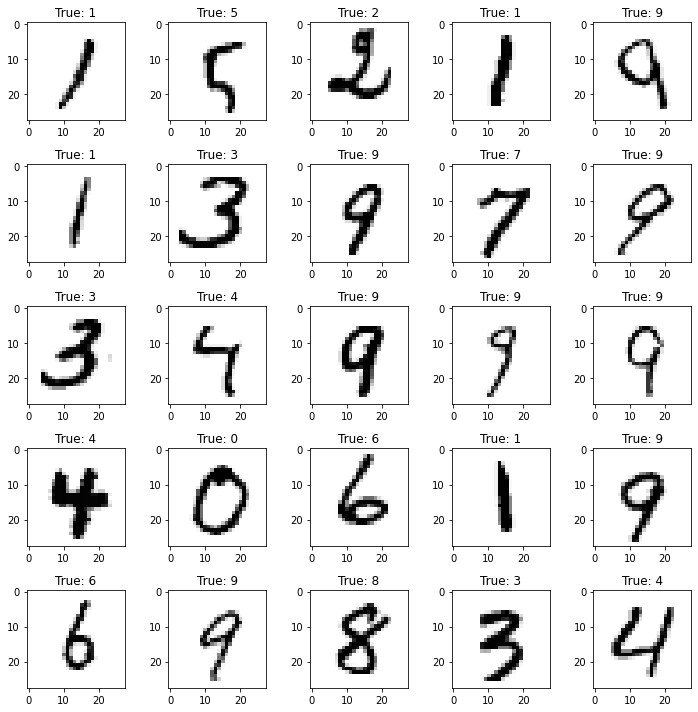

In [ ]:
#mostramos varias imagenes bajo el mismo concepto

images = training.sample(False, 0.01, 1).take(25)
fig, _ = plt.subplots(5, 5, figsize = (10, 10))
for i, ax in enumerate(fig.axes):
    r = images[i]
    label = r.label
    features = r.features
    ax.imshow(features.toArray().reshape(28, 28), cmap = "Greys")
    ax.set_title("True: " + str(label))

plt.tight_layout()

### 5.4. Realizamos consultas sobre el dataframe, queremos saber cuantas filas hay de cada numero

In [ ]:
#crea una tabla temporal para poder realizar consultas SQL puras, la nueva tabla llamada CountResults
training.registerTempTable('CountLabels')

#Creamos un dataframe nuevo que almacena la consulta realizada en SQL sobre la tabla anterior
#la siguiente consulta cuenta cuentos hay de cada categoria resultado
cr = spark.sql("SELECT COUNT(label) AS Cnt, label FROM CountLabels GROUP BY label")
cr.show()

+----+-----+
| Cnt|label|
+----+-----+
|6742|    1|
|5918|    6|
|6131|    3|
|5421|    5|
|5949|    9|
|5842|    4|
|5851|    8|
|6265|    7|
|5958|    2|
|5923|    0|
+----+-----+



In [ ]:
#realizamos una consulta sql para contar cuantos registros hay de cada numero 
counts = training.groupBy("label").count()
type(counts)

pyspark.sql.dataframe.DataFrame

In [ ]:
counts.show()


+-----+-----+
|label|count|
+-----+-----+
|    1| 6742|
|    6| 5918|
|    3| 6131|
|    5| 5421|
|    9| 5949|
|    4| 5842|
|    8| 5851|
|    7| 6265|
|    2| 5958|
|    0| 5923|
+-----+-----+



In [ ]:
#quiero saber si la sumatoria de la columna count da el total de los registros
total = counts.groupBy().sum("count")
total.show()


+----------+
|sum(count)|
+----------+
|     60000|
+----------+



### 5.5 Implementacion del modelo de regresion 

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
#creamos la funcion de regresion logistica con los parametros de entrada (features)(caracteristicas) y la variable objetivo que queremos 
#predecir (label) numero
lr = LogisticRegression(featuresCol="features", 
                        labelCol="label", 
                        regParam=0.1, 
                        elasticNetParam=0.1, 
                        maxIter=10000)

In [ ]:
#creamos el modelo de regresion logistica con los datos de entrenamiento
lr_model = lr.fit(training)

In [ ]:
print("Multinomial coefficients: " + str(lr_model.coefficientMatrix))

Multinomial coefficients: 10 X 784 CSRMatrix
(0,155) 0.0
(0,156) 0.0001
(0,157) 0.0
(0,183) 0.0001
(0,184) 0.0002
(0,185) 0.0002
(0,186) 0.0001
(0,211) 0.0001
(0,212) 0.0002
(0,213) 0.0003
(0,214) 0.0003
(0,215) 0.0001
(0,239) 0.0
(0,240) 0.0001
(0,241) 0.0001
(0,242) 0.0002
..
..


In [ ]:
print("Multinomial intercepts: " + str(lr_model.interceptVector))

Multinomial intercepts: [0.05172460772164002,0.817058931540715,-0.27831372998010345,-0.1379900542129491,0.3049218355895447,0.871143040195552,-0.4311027130366925,0.7787666909556084,-1.5846384909526325,-0.3915701178206827]


In [ ]:
#importamos el dataframe de pruebas 
df_testing = (spark
              .read
              .options(header = False, inferSchema = True)
              .csv("drive/MyDrive/DatosPyspark/mnist_test.csv"))

#realizamos el mismo proceso de construir un nuevo dataframe con 2 columnas, este sera el conjunto de datos utilizado en las pruebas
testing = (vectorizer
           .transform(df_testing)
           .select("_c0", "features")
           .toDF("label", "features")
           .cache())

In [ ]:
df_testing.count()

10000

In [ ]:
#impotamos las funciones de la libreria sql functions, con * se importan todas, solo se necesita "withColumn" el cual devuelve un nuevo dataframe 
# 
from pyspark.sql.functions import *

In [ ]:
# a partir del modelo realizamos predicciones con los datos de pruebas es decir el archivo mnist_test.csv
# queremos saber en que cuales predicciones acertamos y en cuales fallamos, se le agregamos la nueva  linea
# es util para agregar columnas calculadas al dataframe ya existente.
test_pred = lr_model.transform(testing).withColumn("matched", expr("label == prediction"))
test_pred.show(20)

+-----+--------------------+--------------------+--------------------+----------+-------+
|label|            features|       rawPrediction|         probability|prediction|matched|
+-----+--------------------+--------------------+--------------------+----------+-------+
|    7|(784,[202,203,204...|[0.08070480165375...|[0.01163236392094...|       7.0|   true|
|    2|(784,[94,95,96,97...|[1.25425406358767...|[0.02467764471717...|       2.0|   true|
|    1|(784,[128,129,130...|[-1.2276524471688...|[0.00751263994471...|       1.0|   true|
|    0|(784,[124,125,126...|[3.71476062530587...|[0.85536145424016...|       0.0|   true|
|    4|(784,[150,151,159...|[-0.2039270192762...|[0.04549113250992...|       4.0|   true|
|    1|(784,[156,157,158...|[-1.8454996939466...|[0.00278444647289...|       1.0|   true|
|    4|(784,[149,150,151...|[-1.7871799792661...|[0.00965258005973...|       4.0|   true|
|    9|(784,[179,180,181...|[-2.3331144616742...|[0.00711927716793...|       9.0|   true|
|    5|(78

In [ ]:
#miramos el numero aproximado al intervalo de confianza y la probabilidad de que sea
test_pred.select("label", "rawPrediction", "probability").take(2)[1]

Row(label=2, rawPrediction=DenseVector([1.2543, 0.2944, 4.6778, 2.0032, -2.1912, 1.4541, 2.758, -2.0159, 0.5591, -1.5796]), probability=DenseVector([0.0247, 0.0094, 0.757, 0.0522, 0.0008, 0.0301, 0.111, 0.0009, 0.0123, 0.0015]))

### 5.6 Evaluacion del modelo


In [ ]:
#Veamos cuantas observaciones acertamos y cuantas fallamos
test_pred.groupBy("matched").count().show()


+-------+-----+
|matched|count|
+-------+-----+
|   true| 8729|
|  false| 1271|
+-------+-----+



In [ ]:
trainingSummary = lr_model.summary
# para multiclase, podemos inspeccionar métricas por etiqueta
print("Tasa de falsos positivos por etiqueta:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

Tasa de falsos positivos por etiqueta:
label 0: 0.009911792444107476
label 1: 0.021217469675917235
label 2: 0.011990673920284224
label 3: 0.018804878501550056
label 4: 0.014623878282063591
label 5: 0.013759871012660548
label 6: 0.011038792944047927
label 7: 0.01233832697496976
label 8: 0.015309608672366987
label 9: 0.01979611848069416


In [ ]:
print("Tasa de verdaderos positivos por etiqueta:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

Tasa de verdaderos positivos por etiqueta:
label 0: 0.9498564916427487
label 1: 0.969890240284782
label 2: 0.8340046995636119
label 3: 0.8380362094274996
label 4: 0.8892502567613831
label 5: 0.7568714259361742
label 6: 0.9166948293342345
label 7: 0.8836392657621708
label 8: 0.7660229020680226
label 9: 0.8334173810724491


In [ ]:
print("Precisión por etiqueta:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

Precisión por etiqueta:
label 0: 0.9130152547874066
label 1: 0.8526535402268874
label 2: 0.8846359266512374
label 3: 0.8353113314908145
label 4: 0.8677133789878069
label 5: 0.8452822414503502
label 6: 0.9008635004981733
label 7: 0.8930472656880142
label 8: 0.8439088683863679
label 9: 0.8224950232249503


In [ ]:
#Evaluamos que tan precisa fueron las predicciones
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", 
                                               predictionCol="prediction", 
                                               metricName="accuracy")

In [ ]:
#calculamos el porcentantaje de aciertos
evaluator.evaluate(test_pred)*100

87.29

##Clasificador de perceptrón multicapa
El clasificador de perceptrones multicapa (MLPC) es un clasificador basado en la red neuronal artificial feedforward . MLPC consta de múltiples capas de nodos. Cada capa está completamente conectada a la siguiente capa de la red. Los nodos de la capa de entrada representan los datos de entrada. Todos los demás nodos asignan entradas a salidas mediante una combinación lineal de las entradas con los pesos y el sesgo del nodo y aplicando una función de activación. Esto se puede escribir en forma de matriz para MLPC con capas de la siguiente manera: Los nodos en las capas intermedias usan la función sigmoidea (logística): Los nodos en la capa de salida usan la función softmax: El número de nodos en la capa de salida corresponde al número de clases.wbK+1

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from time import time

In [ ]:
#aqui de crea las capas de la red neuronal
start_time = time()
layers = [784, 100, 20, 10]
perceptron = MultilayerPerceptronClassifier(maxIter=1000, layers=layers, blockSize=128, seed=1234)
perceptron_model = perceptron.fit(training)
print("Tiempo tardado: %d" % (time() - start_time))

In [ ]:
type(perceptron_model)

pyspark.ml.classification.MultilayerPerceptronClassificationModel

In [ ]:
test_pred2 = perceptron_model.transform(testing)

In [ ]:
test_pred2.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    7|(784,[202,203,204...|[2.37517885266977...|[2.10102187592847...|       7.0|
|    2|(784,[94,95,96,97...|[-6.7817653343857...|[2.62512603513704...|       2.0|
|    1|(784,[128,129,130...|[-3.7836110112152...|[1.06737099081332...|       1.0|
|    0|(784,[124,125,126...|[13.0487148876553...|[0.99997662114041...|       0.0|
|    4|(784,[150,151,159...|[-3.6702755037471...|[3.90758242409749...|       4.0|
|    1|(784,[156,157,158...|[-4.0487215589126...|[1.40915673378218...|       1.0|
|    4|(784,[149,150,151...|[-6.8400165424598...|[3.75039354719690...|       4.0|
|    9|(784,[179,180,181...|[-6.9042381113852...|[4.22231993644251...|       9.0|
|    5|(784,[129,130,131...|[-0.3590904916427...|[2.62088106026943...|       6.0|
|    9|(784,[209

In [ ]:
# es util para agregar columnas calculadas al dataframe ya existente.
test_pred2 = perceptron_model.transform(testing).withColumn("matched", expr("label == prediction"))


In [ ]:
#mostramos los primero 20 registros del dataframe ya predicho
test_pred2.show()

+-----+--------------------+--------------------+--------------------+----------+-------+
|label|            features|       rawPrediction|         probability|prediction|matched|
+-----+--------------------+--------------------+--------------------+----------+-------+
|    7|(784,[202,203,204...|[2.37517885266977...|[2.10102187592847...|       7.0|   true|
|    2|(784,[94,95,96,97...|[-6.7817653343857...|[2.62512603513704...|       2.0|   true|
|    1|(784,[128,129,130...|[-3.7836110112152...|[1.06737099081332...|       1.0|   true|
|    0|(784,[124,125,126...|[13.0487148876553...|[0.99997662114041...|       0.0|   true|
|    4|(784,[150,151,159...|[-3.6702755037471...|[3.90758242409749...|       4.0|   true|
|    1|(784,[156,157,158...|[-4.0487215589126...|[1.40915673378218...|       1.0|   true|
|    4|(784,[149,150,151...|[-6.8400165424598...|[3.75039354719690...|       4.0|   true|
|    9|(784,[179,180,181...|[-6.9042381113852...|[4.22231993644251...|       9.0|   true|
|    5|(78

In [ ]:
#Veamos cuantas observaciones acertamos y cuantas fallamos con el modelo de redes neuronales
test_pred2.groupBy("matched").count().show()

+-------+-----+
|matched|count|
+-------+-----+
|   true| 9513|
|  false|  487|
+-------+-----+



In [ ]:
#Veamos cuantas observaciones acertamos y cuantas fallamos con el modelo de regresion logistica multinomial
test_pred.groupBy("matched").count().show()

+-------+-----+
|matched|count|
+-------+-----+
|   true| 8729|
|  false| 1271|
+-------+-----+



In [ ]:
#cual es la tasa de acierto
print("Precision:", evaluator.evaluate(test_pred2)*100)


Precision: 95.13000000000001
Tiempo tardado: 1071


In [ ]:
type(perceptron_model)

pyspark.ml.classification.MultilayerPerceptronClassificationModel

In [ ]:
perceptron_model.explainParams()

"blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 128, current: 128)\nfeaturesCol: features column name. (default: features)\ninitialWeights: The initial weights of the model. (undefined)\nlabelCol: label column name. (default: label)\nlayers: Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons. (current: [784, 100, 20, 10])\nmaxIter: max number of iterations (>= 0). (default: 100, current: 1000)\npredictionCol: prediction column name. (default: prediction)\nprobabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)\nrawPredictionCol: raw pred

## Segunda Prueba

In [ ]:
#Realizamos una nueva prueba con una distribucion dsitinta en las capas intermedias de la red feed forward
#aqui de crea las capas de la red neuronal
start_time = time()
layers2 = [784, 100, 10]
red2 = MultilayerPerceptronClassifier(maxIter=1000, layers=layers, blockSize=128, seed=1234)
Red_Model = red2.fit(training)
print("Tiempo tardado: %d" % (time() - start_time))

Tiempo tardado: 9843


In [ ]:
test_pred3 = Red_Model.transform(testing)

In [ ]:
test_pred3.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    7|(784,[202,203,204...|[2.37517885266977...|[2.10102187592847...|       7.0|
|    2|(784,[94,95,96,97...|[-6.7817653343857...|[2.62512603513704...|       2.0|
|    1|(784,[128,129,130...|[-3.7836110112152...|[1.06737099081332...|       1.0|
|    0|(784,[124,125,126...|[13.0487148876553...|[0.99997662114041...|       0.0|
|    4|(784,[150,151,159...|[-3.6702755037471...|[3.90758242409749...|       4.0|
|    1|(784,[156,157,158...|[-4.0487215589126...|[1.40915673378218...|       1.0|
|    4|(784,[149,150,151...|[-6.8400165424598...|[3.75039354719690...|       4.0|
|    9|(784,[179,180,181...|[-6.9042381113852...|[4.22231993644251...|       9.0|
|    5|(784,[129,130,131...|[-0.3590904916427...|[2.62088106026943...|       6.0|
|    9|(784,[209

In [ ]:
# es util para agregar columnas calculadas al dataframe ya existente.
test_pred3 = Red_Model.transform(testing).withColumn("matched", expr("label == prediction"))

In [ ]:
test_pred3.show()

+-----+--------------------+--------------------+--------------------+----------+-------+
|label|            features|       rawPrediction|         probability|prediction|matched|
+-----+--------------------+--------------------+--------------------+----------+-------+
|    7|(784,[202,203,204...|[2.37517885266977...|[2.10102187592847...|       7.0|   true|
|    2|(784,[94,95,96,97...|[-6.7817653343857...|[2.62512603513704...|       2.0|   true|
|    1|(784,[128,129,130...|[-3.7836110112152...|[1.06737099081332...|       1.0|   true|
|    0|(784,[124,125,126...|[13.0487148876553...|[0.99997662114041...|       0.0|   true|
|    4|(784,[150,151,159...|[-3.6702755037471...|[3.90758242409749...|       4.0|   true|
|    1|(784,[156,157,158...|[-4.0487215589126...|[1.40915673378218...|       1.0|   true|
|    4|(784,[149,150,151...|[-6.8400165424598...|[3.75039354719690...|       4.0|   true|
|    9|(784,[179,180,181...|[-6.9042381113852...|[4.22231993644251...|       9.0|   true|
|    5|(78

In [ ]:
test_pred3.groupBy("matched").count().show()

+-------+-----+
|matched|count|
+-------+-----+
|   true| 9513|
|  false|  487|
+-------+-----+



## Tercera Prueba

In [ ]:
#Realizamos una nueva prueba con una distribucion dsitinta en las capas intermedias de la red feed forward
#aqui de crea las capas de la red neuronal
start_time = time()
layers3 = [784, 50, 10]
red3 = MultilayerPerceptronClassifier(maxIter=1000, layers=layers, blockSize=128, seed=1234567890)
Red_Model3 = red3.fit(training)
print("Tiempo tardado: %d" % (time() - start_time))

Tiempo tardado: 6349


In [ ]:
test_pred4 = Red_Model3.transform(testing)

In [ ]:
test_pred4.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    7|(784,[202,203,204...|[-4.5759246181917...|[6.47842375128777...|       7.0|
|    2|(784,[94,95,96,97...|[2.54466129240989...|[1.27257436339794...|       2.0|
|    1|(784,[128,129,130...|[-8.0917859092943...|[6.09302654279281...|       1.0|
|    0|(784,[124,125,126...|[10.4538809243357...|[0.99826588560692...|       0.0|
|    4|(784,[150,151,159...|[-1.6103951867442...|[2.39902837501095...|       4.0|
|    1|(784,[156,157,158...|[-8.5636488628644...|[6.59705361444784...|       1.0|
|    4|(784,[149,150,151...|[-4.5801869505142...|[4.38356211504523...|       4.0|
|    9|(784,[179,180,181...|[-4.2495186052355...|[2.86686610138415...|       9.0|
|    5|(784,[129,130,131...|[0.61275905455161...|[3.14461993185612...|       5.0|
|    9|(784,[209

In [ ]:
# es util para agregar columnas calculadas al dataframe ya existente.
test_pred4 = Red_Model3.transform(testing).withColumn("matched", expr("label == prediction"))

In [ ]:
Red_Model3.take(1)

AttributeError: ignored

In [ ]:
test_pred4.show()

+-----+--------------------+--------------------+--------------------+----------+-------+
|label|            features|       rawPrediction|         probability|prediction|matched|
+-----+--------------------+--------------------+--------------------+----------+-------+
|    7|(784,[202,203,204...|[-4.5759246181917...|[6.47842375128777...|       7.0|   true|
|    2|(784,[94,95,96,97...|[2.54466129240989...|[1.27257436339794...|       2.0|   true|
|    1|(784,[128,129,130...|[-8.0917859092943...|[6.09302654279281...|       1.0|   true|
|    0|(784,[124,125,126...|[10.4538809243357...|[0.99826588560692...|       0.0|   true|
|    4|(784,[150,151,159...|[-1.6103951867442...|[2.39902837501095...|       4.0|   true|
|    1|(784,[156,157,158...|[-8.5636488628644...|[6.59705361444784...|       1.0|   true|
|    4|(784,[149,150,151...|[-4.5801869505142...|[4.38356211504523...|       4.0|   true|
|    9|(784,[179,180,181...|[-4.2495186052355...|[2.86686610138415...|       9.0|   true|
|    5|(78

In [ ]:
test_pred4.groupBy("matched").count().show()

+-------+-----+
|matched|count|
+-------+-----+
|   true| 9538|
|  false|  462|
+-------+-----+



In [ ]:
#cual es la tasa de acierto
print("Precision:", evaluator.evaluate(test_pred4)*100)


Precision: 95.38


### 5.7 Guardar los resultados en disco

In [ ]:
#convertimos a RDD 
Resultrdd = test_pred.rdd.map(list)

In [ ]:
#guarda los datos en un solo archivo
Resultrdd.repartition(1).saveAsTextFile("drive/MyDrive/DatosPyspark/Output_Pyspark")

## Guardar los Modelos Ya entrenados

In [ ]:
import sys
import os

In [ ]:
#guardo el modelo 784,50,10
Red_Model3.save[1](os.path.join(sys.argv[1], 'model_3'))

In [ ]:
Resultrdd = Red_Model3.rdd.map(list)

AttributeError: ignored

In [ ]:
Red_Model3.save(os.path.join(sys.argv[1],'drive/MyDrive/DatosPyspark/Output_Pyspark/Model'))

In [ ]:
Red_Model3.save('drive/MyDrive/DatosPyspark/Output_Pyspark/Model')

In [ ]:
modeloentre

## Cargar los Modelos ya entrenados

In [ ]:
#carga del modelo 784,50,10
model_preentrenado = MultilayerPerceptronClassifier.load(os.path.join(sys.argv[1], 'model_3'))

Py4JJavaError: ignored